In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torchvision.transforms as transforms
import torchvision.models as models

import copy

import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys

import numpy as np
import cv2


PyTorch version: 2.0.1+cu117
Torchvision version: 0.15.2+cu117
CUDA is available: True


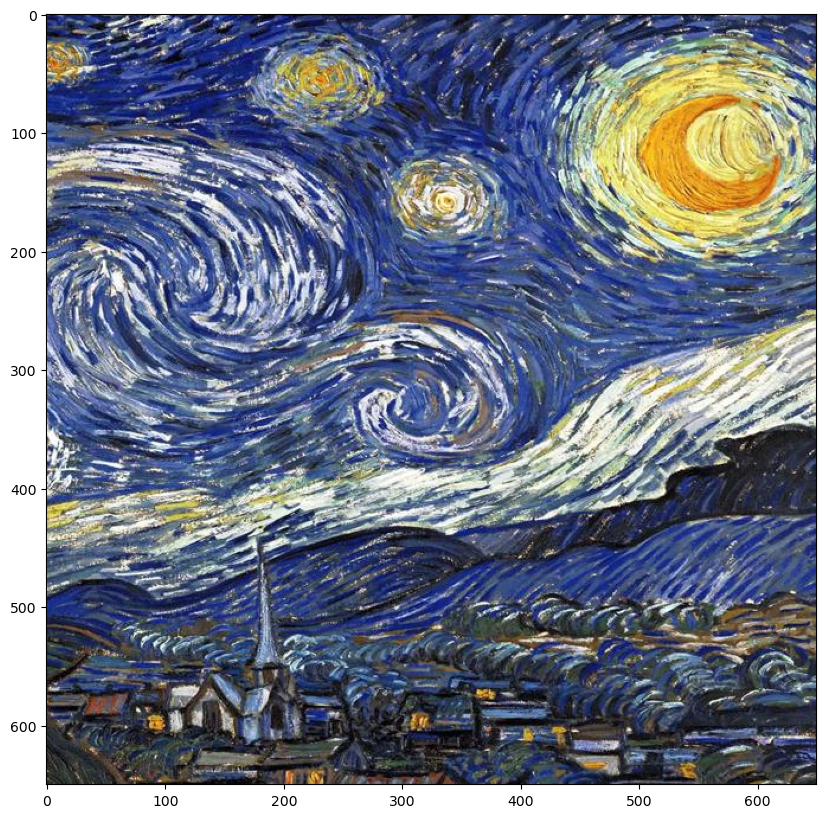

In [2]:
## user defines
imsize = 650  # use small size if no GPU
image_loc = './images/starry_night.jpg'

image = Image.open(image_loc)
image2 = image.resize((imsize,imsize))
image_loc = '.' + image_loc.split('.')[-2] + '_' + str(imsize) + '.' +image_loc.split('.')[-1]
image2.save(image_loc)

image = cv2.imread(image_loc)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [3]:

# importing the module
import cv2

x_store  = []
y_store  = []
# function to display the coordinates of
# of the points clicked on the image 
def click_event(event, x, y, flags, params):
  
    # checking for left mouse clicks
    if event == cv2.EVENT_LBUTTONDOWN:
  
        # displaying the coordinates
        # on the Shell
        print(x, ' ', y)
        x_store.append(x)
        y_store.append(y)
        # displaying the coordinates
        # on the image window
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, str(x) + ',' +
                    str(y), (x,y), font,
                    1, (255, 0, 0), 2)
        cv2.circle(img, (x,y), 3, (0,255,255), -1)
        cv2.imshow('image', img)
  
    # checking for right mouse clicks     
#     if event==cv2.EVENT_RBUTTONDOWN:
  
#         # displaying the coordinates
#         # on the Shell
#         print(x, ' ', y)
  
#         # displaying the coordinates
#         # on the image window
#         font = cv2.FONT_HERSHEY_SIMPLEX
#         b = img[y, x, 0]
#         g = img[y, x, 1]
#         r = img[y, x, 2]
#         cv2.putText(img, str(b) + ',' +
#                     str(g) + ',' + str(r),
#                     (x,y), font, 1,
#                     (255, 255, 0), 2)
#         cv2.circle(img, (x,y), 3, (0,255,255), -1)
#         cv2.imshow('image', img)
  
img = cv2.cvtColor(np.array(image2), cv2.COLOR_RGB2BGR) # convert from PIL image to cv2 image
cv2.imshow('image', img)
cv2.setMouseCallback('image', click_event)
cv2.waitKey(0) # Close window after a key press
cv2.destroyAllWindows()


## Method 2 to get points
# while True:
#     pointx = int(input("Please insert x axis coordinate: "))
#     if pointx > imsize or pointx < 0:
#         print(f"Please insert an appropriate x axis coordinate of value > imsize ({imsize}) \n")
#         continue
#     pointy = int(input("Please insert y axis coordinate: "))
#     if pointy > imsize or pointy < 0:
#         print(f"Please insert an appropriate y axis coordinate of value > imsize ({imsize}) \n")
#         continue
#     break

370   93


In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [5]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"
device = 'cpu'  ## CUDA memory ran out

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

predictor.set_image(image)

In [6]:
input_point = np.array([[x_store[-1],y_store[-1]]])
input_label = np.array([1])
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

Best Mask by Score, Score: 0.974


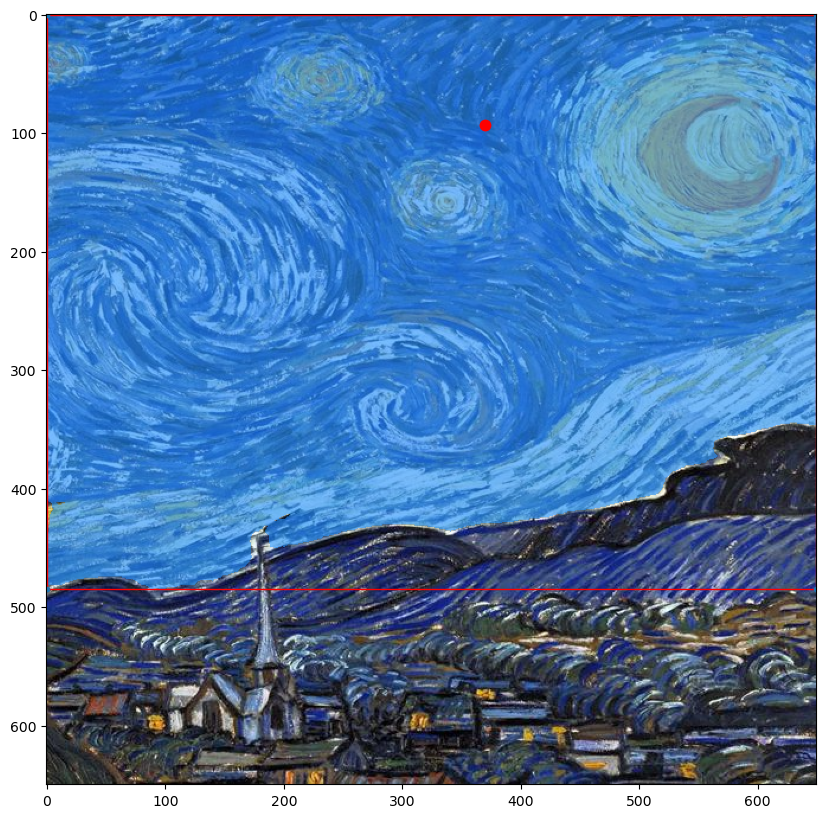

In [9]:
### if multiple masks
best_mask = scores.argmax()
minrow,mincol,maxrow,maxcol=len(masks[best_mask]),len(masks[best_mask][0]),-1,-1
shape = masks.shape
rows,cols = shape[1],shape[2]
for row in range(rows):
    for col in range(cols):
        if masks[best_mask][row][col] == True:
            if row < minrow:
                minrow = row
            if row > maxrow:
                maxrow = row
            if col < mincol:
                mincol = col
            if col > maxcol:
                maxcol = col

box = [minrow,mincol,maxrow,maxcol]
box = [mincol,minrow,maxcol,maxrow]


plt.figure(figsize=(10,10))
plt.imshow(image)
ax = plt.gca()
show_mask(masks[best_mask], plt.gca())
plt.plot([mincol,maxcol,mincol,maxcol],[maxrow,minrow,minrow,maxrow],'.')  # x is col, y is row
plt.plot(x_store[-1],y_store[-1],'.',color='red',markersize=15)
rect = patches.Rectangle((mincol, minrow),   maxcol-mincol,maxrow-minrow, linewidth=1, edgecolor='r', facecolor='none')
# show_box(box, ax)
ax.add_patch(rect)
print(f"Best Mask by Score, Score: {scores[best_mask]:.3f}")
plt.axis('on')
plt.show()  

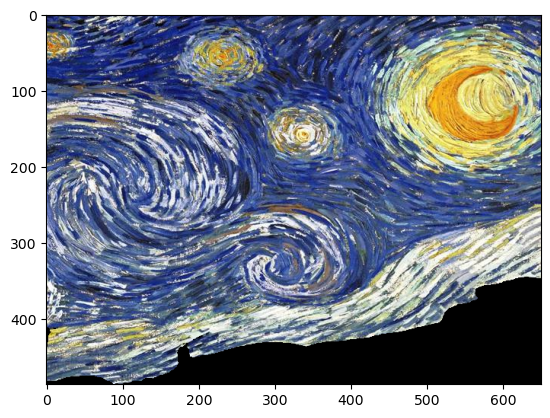

In [24]:
## Method 1 : Black out pixels that are not part of the segment

shaded_image = image * masks[best_mask].reshape(rows,cols,1) # shades non segmented image as black
boxed_region = shaded_image[minrow:maxrow+1,mincol:maxcol+1,:] 
plt.imshow(boxed_region)

## Method 2 : Train style and content image together? 